# Bonsai Boosted Decision Tree generator 
This script has been created to retrain PatLongLivedTracking's seed classifier.  
It also generates the c++ code that can be used within the PatLongLivedTracking class.   

The following script contains such steps as: 
1. Convert training NTuple into pandas DataFrame
2. Train the bonsai Boosted Decision Tree 
    * This script contains only final model training. The entire Machine Learning study contains model selection, tuning hyper-parameters and features engineering can be found [here](https://github.com/adendek/DownstreamTracking)
    * The bBDT is based on hep_ml.speedup.LookupClassifier with xgboost as a base classifier
3. Generate the tuple classifier (root file)
4. Generate C++ code. This code can be deployed into PatLongLivevTracking class.   



In [1]:
print ("kernel is alive!")

kernel is alive!


In [1]:
import root_numpy
import root_pandas
import pandas as pd
import itertools
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search

import xgboost as xgb

from hep_ml.speedup import LookupClassifier

Welcome to ROOTaaS 6.06/02


## As a very first step I need to convert training data from root NTpule into pandas DataFrame 

To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe  
At first the training file name have to be defined

In [9]:
training_file_name = "datasets/Brunel_test_30kev.root"

In [10]:
root_file = ROOT.TFile(training_file_name)
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [11]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [12]:
new_data = basic_transforamtion(data)
new_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


### Balance the training dataset

In [13]:
good_track_no = counts = new_features[target == 1].count()[0]
ghost_track_no = counts = new_features[target == 0].count()[0]
print("good tracks %d") % good_track_no
print("ghost track %d") % ghost_track_no
ratio_ghost_to_good = float(ghost_track_no)/good_track_no
ratio_ghost_to_good = numpy.round(ratio_ghost_to_good, 3)
print ("ratio ghost to good %f") % ratio_ghost_to_good

good tracks 178831
ghost track 2641394
ratio ghost to good 14.770000


In [14]:
new_features = new_features.drop(["seed_x","seed_y","seed_ty","seed_tx","seed_p"], axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,1187.267858,25,0,12,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,1204.396954,25,0,12,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,1708.511389,25,0,12,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,1823.936187,25,0,12,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,1252.585447,24,0,12,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


## Train the bonsai Boosted Decision Tree classifier
As mentiond before the hyperparameters of the based classifier has beed selected in advance. 

In [15]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              

n_bins = 4

base_classifier = xgb.XGBClassifier(n_estimators=400, learning_rate=0.07 ,scale_pos_weight=ratio_ghost_to_good, max_depth=6)
classifier = LookupClassifier(base_estimator=base_classifier, n_bins=n_bins, keep_trained_estimator=False)
classifier.fit(train_X, train_Y)

LookupClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=14.77, seed=0, silent=True, subsample=1),
         keep_trained_estimator=False, max_cells=500000000, n_bins=4)

### Check the model performance

In [16]:
print "ROC AUC score of binarized XGBoost with 400 trees and trained using scale positive weight"
roc_auc_score(test_Y, classifier.predict_proba(test_X)[:, 1])

ROC AUC score of binarized XGBoost with 400 trees and trained using scale positive weight


0.77325737147769302

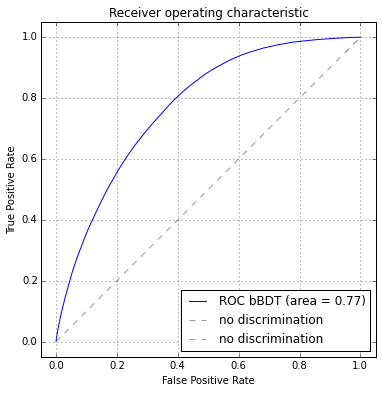

In [17]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, classifier.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC bBDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

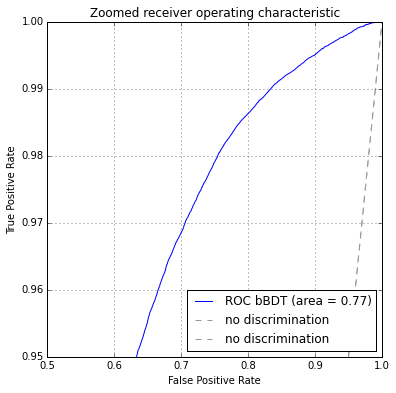

In [18]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, classifier.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC bBDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.5, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## The generation of the T-Seed classifier starts here

### Create the tuple classifier. 


In [19]:
n_features = new_features.shape[1]
all_bins_indices = list(itertools.product(range(n_bins), repeat=n_features)) 
all_bins_indices_df = pd.DataFrame(all_bins_indices,columns=new_features.columns.values )
all_bins_indices_df.head()

,seed_chi2PerDoF,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,1,0


In [20]:
lookup_indices = classifier.convert_bins_to_lookup_index(all_bins_indices_df)
predictions = numpy.array(classifier._lookup_table[lookup_indices] [:,1])

all_bins_indices_df['pred'] = predictions
all_bins_indices_df.head()

,seed_chi2PerDoF,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity,pred
0,0,0,0,0,0,0,0,0,0,0,0,0.254758
1,0,0,0,0,0,0,0,0,0,0,1,0.290244
2,0,0,0,0,0,0,0,0,0,0,2,0.011093
3,0,0,0,0,0,0,0,0,0,0,3,0.007577
4,0,0,0,0,0,0,0,0,0,1,0,0.240432


### Save the tuple classifier as a root tree into file. 

In [21]:
from root_pandas import to_root
!mkdir -p  models/cpp/
to_root(all_bins_indices_df, 'models/cpp/tuple_classifer.root', key = 'tree')

## Generate classifer's c++ code

The next step is to generate source code of the class responsible for evaluation of the bBDT classifier.  
The template has been written manualy using CLion IDE.  

There will be 2 python function:
1. Generate header file (PatBBDTSeedClassifier.h)  
2. Generate cpp source  file (PatBBDTSeedClassifier.cpp)

In [22]:
def generate_header():
    header =  """
/** This file was generated automaticly by python script 
https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/BDT-XGBoost.ipynb
DO NOT MODIFY IT MANUALLY!!!!!!
*/
    
#pragma once

#include "PatKernel/IPatMvaClassifier.h"
#include "PatKernel/IPatMvaClassifier.h"
#include "GaudiAlg/GaudiTool.h"

#include <vector>
#include <map>
#include <TROOT.h>
#include <TFile.h>
#include <TTree.h>


class PatBBDTSeedClassifier : public GaudiTool, virtual public IPatMvaClassifier
{
public:
    PatBBDTSeedClassifier( const std::string& type,
                           const std::string& name,
                           const IInterface* parent);

    double getMvaValue(const std::vector<double>& parametersVector );

    virtual StatusCode initialize();



private:
    //initialization phase
    void initBinEdgeMaps();
    void initTupleClassifier();

    // model prediction phase
    double getBBDTPrediction(const std::vector<int>& binIndices);
    std::vector<int> getBinIndices(const std::vector<double>& parametersVector);


    std::vector <std::pair<std::string, std::vector<double>>> m_binsEdgeMap;
    std::map <std::vector<int>, double > m_tupleClassifier;


    // tree specific member fields

    // Declaration of leaf types
    std::vector<Double_t*> m_leafTypes;
"""
    for feature in all_bins_indices_df.columns.values:
        header += "\t Double_t     "+ str(feature)+";\n"


    header+="// List of branches\n"
    for feature in all_bins_indices_df.columns.values:
        header += "\t TBranch    *b_"+str(feature) +";\n"

    header+= "};\n"
    return header

In [23]:
def generate_source_file():
    source = """
#include "PatBBDTSeedClassifier.h"
#include <stdlib.h>
#include <stdio.h>

DECLARE_TOOL_FACTORY( PatBBDTSeedClassifier )

double PatBBDTSeedClassifier::getMvaValue(const std::vector<double>& parametersVector )
{
    auto binIndices = getBinIndices(parametersVector);
    return getBBDTPrediction(binIndices);
}




PatBBDTSeedClassifier::PatBBDTSeedClassifier( const std::string& type,
                                                const std::string& name,
                                                const IInterface* parent )
        : GaudiTool ( type, name , parent )
{
    declareInterface<IPatMvaClassifier>(this);
}


StatusCode PatBBDTSeedClassifier::initialize()
{
    StatusCode sc =  GaudiTool::initialize();
    if(sc.isFailure()) return Error("Failed to initialize", sc);

    initBinEdgeMaps();
    initTupleClassifier();
    return StatusCode::SUCCESS;
}

std::vector<int> PatBBDTSeedClassifier::getBinIndices(const std::vector<double>& parametersVector)
{
    int actualFeature = 0;
    int binPerFeatures = 2;
    std::vector<int> binIndicesMap;
    for (const auto& featurePair: m_binsEdgeMap){
        int binNumber = 0;
        for(const auto& binValue : featurePair.second) {
            if (parametersVector[actualFeature] < binValue) {
                binIndicesMap.push_back(binNumber);
                break;
            }
            binNumber++;
            if(binNumber == binPerFeatures -1 ) binIndicesMap.push_back(binNumber);

        }
        actualFeature++;
    }
    return binIndicesMap;
}

double PatBBDTSeedClassifier::getBBDTPrediction(const std::vector<int>& binIndices)
{
    return m_tupleClassifier[binIndices];
}

void PatBBDTSeedClassifier::initTupleClassifier() {
    TTree *tree = 0;
    TFile *f = (TFile *) gROOT->GetListOfFiles()->FindObject("tuple_classifer.root");
    if (!f || !f->IsOpen()) {
        f = new TFile("/afs/cern.ch/user/a/adendek/tracking_brunel/BrunelDev_v51r0/Tf/PatAlgorithms/src/tuple_classifer.root");
    }
    f->GetObject("tree", tree);
"""
    for feature in all_bins_indices_df.columns.values:
        source += "\t tree->SetBranchAddress(\""+ str(feature)+ "\", &"+str(feature)+", &b_"+str(feature)+");\n"

    for feature in all_bins_indices_df.columns.values:
        source += "\t m_leafTypes.push_back(&"+ str(feature)+");\n"
    source += """
    Long64_t nentries = tree->GetEntriesFast();
    for (Long64_t jentry = 0; jentry < nentries; jentry++) {
        tree->GetEntry(jentry);
        std::vector<int> binIndices;
        for (const auto &leaf : m_leafTypes) {
            binIndices.push_back(*leaf);
        }
        m_tupleClassifier.insert(std::make_pair(binIndices, pred));
    }
    
}
"""
    return source

In [24]:
def generate_InitBinEdgeMap_function():
    function_body = """
void PatBBDTSeedClassifier::initBinEdgeMaps()
{
    m_binsEdgeMap ={
    """
    for feature, bins_edges in classifier.bin_edges.iteritems():
        function_body += "\t {\"" + str(feature) +"\", {"
        for bin_edge in bins_edges:
            function_body += str(bin_edge)+ ","
        function_body +=  "}},\n"
    
    function_body += """\n };
}
    """
    return function_body

In [25]:
file = open("models/cpp/PatBBDTSeedClassifier.h", 'w')
file.write(generate_header())
file.close()

file = open("models/cpp/PatBBDTSeedClassifier.cpp", 'w')
file_content = generate_source_file()
file_content += generate_InitBinEdgeMap_function()

file.write(file_content)
file.close()

## Now you need to manualy copy all generated files into **Tf/PatAlgorithms/src/**